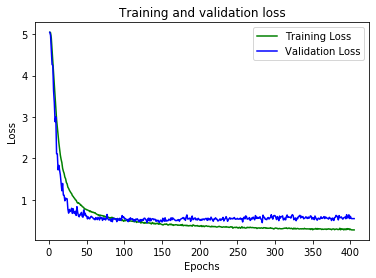

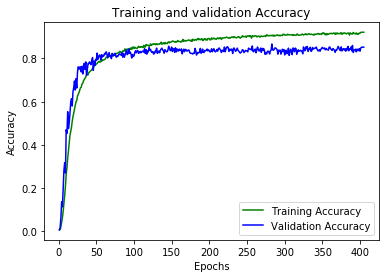

In [1]:
import utilities
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout , SpatialDropout2D, BatchNormalization, SeparableConv2D
from tensorflow.keras.layers import AveragePooling2D, Activation
from tensorflow.keras.callbacks import History
import numpy as np
import pandas as pd
import os
import tensorflow.keras as keras
from  tensorflow.keras import optimizers, initializers
from tensorflow.keras import regularizers
from tensorflow.keras import losses
from tensorflow.keras.regularizers import l1_l2, l1,l2
from tensorflow.keras.models import model_from_json
from sklearn.utils import class_weight
import pyprog
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
!find '.' -name '*.ipynb_checkpoints' -exec rm -r {} +


In [2]:
#set the paths and sizes
SETTINGS_DIR = os.path.dirname(os.path.realpath('__file__'))
train_set_path = SETTINGS_DIR+'/images/Control/Train/'
test_set_path = SETTINGS_DIR+"/images/Control/Test/"

dnn_file_name_structure = SETTINGS_DIR +"/cnn_control-new-Resnet.json"
training_dynamics_path = SETTINGS_DIR+'/TrainingDynamics-new-Resnet.csv'
dnn_file_name_weights = SETTINGS_DIR +  "/cnn_weight_control-new-Resnet.h5"

batch_size=128
image_input_size=(150,150)
vocab_size = utilities.get_no_folders_in_path(test_set_path)
print ("Vocabulary Size:",vocab_size)

Vocabulary Size: 155


In [6]:
#make the model
def model_compile(model,learning_rate=0.001):
    print('learning_rate', learning_rate)
    model.compile(loss=losses.categorical_crossentropy,
                          optimizer=optimizers.Adam(learning_rate),
                          metrics=['accuracy'])
    
def get_model():


    droprate=0.35
    regularizer=regularizers.l2(1e-2)
    #droprate2=0.5
    classifier = Sequential()
    classifier.add( SeparableConv2D( filters=32, kernel_size=(3,3),kernel_regularizer=regularizer, input_shape= (*image_input_size,3), activation='relu'))    
    classifier.add( SpatialDropout2D(droprate) )
    classifier.add(BatchNormalization())
    classifier.add(MaxPooling2D (pool_size=(2,2) ) )
    #classifier.add(Dropout(droprate))
    
    classifier.add(SeparableConv2D(filters=64, kernel_size=(3, 3),kernel_regularizer=regularizer, activation='relu'))
    classifier.add( SpatialDropout2D(droprate) )
    classifier.add(BatchNormalization())
    classifier.add(MaxPooling2D(pool_size=(2, 2)))
    
    classifier.add(SeparableConv2D(filters=128, kernel_size=(3, 3),kernel_regularizer=regularizer, activation='relu'))
    classifier.add( SpatialDropout2D(droprate) )
    #classifier.add(MaxPooling2D(pool_size=(2, 2)))
    classifier.add(BatchNormalization())
    #classifier.add(Dropout(droprate))
    
    classifier.add(SeparableConv2D(filters=256, kernel_size=(3, 3),kernel_regularizer=regularizer, activation='relu'))
    classifier.add( SpatialDropout2D(droprate) )
    classifier.add(MaxPooling2D(pool_size=(2, 2)))
    classifier.add(Dropout(droprate))
    
    classifier.add (Flatten( ) )
    classifier.add(Dense (units=vocab_size, kernel_regularizer=regularizer, activation='softmax' ))
    classifier.summary()
    return classifier











In [4]:
def read_epoch():
    if os.path.exists(training_dynamics_path):
        training_dynamics=pd.read_csv(training_dynamics_path)
        return training_dynamics["Epoch"][len(training_dynamics)-1]
    else:
        return 0

def load_model(learning_rate=0.001):
    # Loading the CNN
    json_file = open(dnn_file_name_structure, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # load weights into new model
    #print(dnn_file_name_weights)
    model.load_weights(dnn_file_name_weights)
    model_compile(model,learning_rate)
    return model

def save_model(model):
    # Save/overwrite the model
    model_json = model.to_json()
    with open(dnn_file_name_structure, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(dnn_file_name_weights)
# 'acc' is changed to accuracy in new keras
def save_training_dynamics(epoch,history,with_header=False):
    training_dynamics=pd.DataFrame(
        data = [ [epoch, history.history['loss'][0] ,  history.history['accuracy'][0],  
                history.history['val_loss'][0],  history.history['val_accuracy'][0] ]],
        columns=["Epoch","TrainingLoss", "TrainingAccuracy","ValidationLoss","ValidationAccuracy"]
    )
    if (with_header):
        with open(training_dynamics_path, 'a') as csv_file:
            training_dynamics.to_csv(csv_file, header=True)
    else:
        with open(training_dynamics_path, 'a') as csv_file:
            training_dynamics.to_csv(csv_file, header=False)

In [5]:
def get_train_test_sets():
        from tensorflow.keras.preprocessing.image import ImageDataGenerator
        
        # https://fairyonice.github.io/Learn-about-ImageDataGenerator.html
        train_datagen = ImageDataGenerator(
                    rescale=1./255,
            width_shift_range=0.30,
            shear_range=0.2,
            zoom_range=0.2,
            fill_mode='nearest',
            horizontal_flip=False)
        orig_img=SETTINGS_DIR+"/images/Control/Test/C10/CM06_B1_C10_M3.jpg"
        #generate_plot_pics(train_datagen,orig_img)
        test_datagen = ImageDataGenerator(rescale=1./255)
        
        # If shuffle=False then the validation results will be different from classifier.predict_generator()
        training_set = train_datagen.flow_from_directory(
            train_set_path,
            target_size=image_input_size,
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=True)
        #print(training_set[0])
        test_set = test_datagen.flow_from_directory(
           test_set_path,
            target_size=image_input_size,
            batch_size=batch_size,
            class_mode='categorical',
            shuffle=False)
        return training_set, test_set

In [6]:
#traing of the model
def train(ideal_loss=0.01, is_dnn_structure_changned=False,
              learning_rate=0.001,  max_epoch=50, enabled_trasfer_learning=False):
        
        is_new_dnn=False
        history = History()
        
        print("=================================================")
        
        if (os.path.isfile(dnn_file_name_structure) and
                (os.path.isfile(dnn_file_name_weights)) and 
                (is_dnn_structure_changned == False)):
            # load the previosly trained DNN
            if (enabled_trasfer_learning):
                # Enable Transfer Learning
                print ("Transfer learning is enabled.")
                model = FreezeLayers(load_model(),top_unfrozen_layer_name="conv2d_5" ) 
            else:
                print ("Transer learning is disabled.")
                model = load_model(learning_rate=learning_rate)
            print("CNN is loaded.")
        else:
            # Create a new model
            model =  get_model()                    
            print("CNN is created")
            # Erase the training_dynamic_csv file
            if os.path.exists(training_dynamics_path):
                os.remove(training_dynamics_path)
            is_new_dnn=True
            model_compile(model)
        
        ep= read_epoch()+1
        #PringFrozenLayers(model)
        #model.fit_generator instead of model.fit 
        # instead of callbacks=[history] now history=model.fit()
        history=model.fit(
            training_set,
            steps_per_epoch=training_set.samples/batch_size,
            #steps_per_epoch=500,
                             epochs=1,
                           
                             validation_data=test_set,
                             validation_steps=test_set.samples/batch_size,
                             workers=10, 
                             max_queue_size=10)
        save_training_dynamics(ep,history,with_header=is_new_dnn)
       
        while (history.history['loss'][0] >= ideal_loss):
            print("Epoch", ep)
            history=model.fit(
            training_set,
            steps_per_epoch=training_set.samples/batch_size,
            #steps_per_epoch=500,
                             epochs=1,
                             
                             validation_data=test_set,
                             validation_steps=test_set.samples/batch_size,
                             workers=10,
                             max_queue_size=10)

            # Save/overwrite the model
            #print('model saved')
            save_model(model)
            '''
            if (ep%5==0):
                
                if(manual_testing()>0.85):
                    break
                
            '''
            if   (history.history['val_accuracy'][0]>0.98):
                break
                
            ep += 1
            save_training_dynamics(ep,history,with_header=False)        

            # stop the traning if certain training accuracy is reached
            if (history.history['loss'][0]<ideal_loss):
                   break
            if (ep > max_epoch):
                break

        return history

In [7]:
training_set, test_set =get_train_test_sets()

Found 15736 images belonging to 155 classes.
Found 1395 images belonging to 155 classes.


In [8]:
history = train(is_dnn_structure_changned= False, learning_rate=0.0001, max_epoch=5000)

Transer learning is disabled.
learning_rate 0.0001
CNN is loaded.
122/122 [==============================] - 50s 376ms/step - loss: 0.2509 - accuracy: 0.9676 - val_loss: 0.3219 - val_accuracy: 0.9470
Epoch 492
122/122 [==============================] - 46s 367ms/step - loss: 0.2473 - accuracy: 0.9678 - val_loss: 0.3319 - val_accuracy: 0.9455
Epoch 493
122/122 [==============================] - 46s 369ms/step - loss: 0.2490 - accuracy: 0.9665 - val_loss: 0.3167 - val_accuracy: 0.9441
Epoch 494
122/122 [==============================] - 47s 369ms/step - loss: 0.2552 - accuracy: 0.9647 - val_loss: 0.3327 - val_accuracy: 0.9455
Epoch 495
122/122 [==============================] - 46s 368ms/step - loss: 0.2522 - accuracy: 0.9684 - val_loss: 0.3307 - val_accuracy: 0.9405
Epoch 496
122/122 [==============================] - 46s 367ms/step - loss: 0.2525 - accuracy: 0.9680 - val_loss: 0.3608 - val_accuracy: 0.9477
Epoch 497
122/122 [==============================] - 46s 368ms/step - loss: 0.24

KeyboardInterrupt: 

In [7]:
model = load_model(learning_rate=0.0001)

learning_rate 0.0001


In [8]:
model.summary()

Model: "ResNet-Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
separable_conv2d (SeparableConv (None, 150, 150, 16) 91          input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout2d (SpatialDropo (None, 150, 150, 16) 0           separable_conv2d[0][0]           
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 150, 150, 16) 64          spatial_dropout2d[0][0]          
_______________________________________________________________________________________